# Data E-Coli

## Bussiness Understanding

Tujuan :
1. Memahami Data: Melakukan analisis eksplorasi untuk memahami karakteristik setiap fitur dan distribusi kelas target.
2. Preprocessing & Visualisasi Awal: Menyiapkan data dan memvisualisasikan data asli menggunakan PCA (Principal Component Analysis) untuk melihat bagaimana kelas-kelas terpisah dalam ruang 2 dimensi.
3. Penyeimbangan Data: Mengatasi masalah ketidakseimbangan kelas menggunakan teknik oversampling ADASYN (Adaptive Synthetic Sampling) untuk menghasilkan data sintetis bagi kelas minoritas.
4. Visualisasi Akhir: Memvisualisasikan kembali data yang telah diseimbangkan menggunakan PCA untuk membandingkan distribusinya dengan data asli dan menyorot data baru yang dihasilkan.

(Langkah Selanjutnya) Setelah data seimbang, langkah berikutnya adalah melatih dan mengevaluasi beberapa model klasifikasi untuk menemukan yang terbaik.

## Data Understanding

Sumber Data :
Dataset Ecoli ini berasal dari UCI Machine Learning Repository dan dikelola oleh Kenta Nakai. Dataset ini berisi 336 sampel protein E. coli.

Deskripsi Atribut :
Dataset memiliki 8 atribut, yang terdiri dari 1 nama sekuens (sebagai identifier) dan 7 atribut prediktif (fitur).
| Nama Atribut | Tipe Data | Deskripsi |
| :--- | :--- | :--- |
| **Sequence Name** | Teks | [cite_start]Nomor akses untuk database SWISS-PROT[cite: 67]. |
| **mcg** | Numerik | [cite_start]Skor metode McGeoch untuk pengenalan sinyal sekuens[cite: 67]. |
| **gvh** | Numerik | [cite_start]Skor metode von Heijne untuk pengenalan sinyal sekuens[cite: 68]. |
| **lip** | Kategorikal (Biner) | [cite_start]Skor konsensus sinyal Peptidase II von Heijne[cite: 69]. |
| **chg** | Kategorikal (Biner) | [cite_start]Kehadiran muatan pada N-terminus dari lipoprotein yang diprediksi[cite: 70]. |
| **aac** | Numerik | [cite_start]Skor analisis diskriminan dari kandungan asam amino[cite: 71]. |
| **alm1** | Numerik | [cite_start]Skor dari program prediksi ALOM untuk region transmembran[cite: 72]. |
| **alm2** | Numerik | [cite_start]Skor program ALOM setelah mengecualikan sinyal sekuens[cite: 73]. |
| **Localization Site**| Kategorikal | [cite_start]Lokasi protein di dalam sel (kelas target)[cite: 63]. |

Distribusi Kelas :
Distribusi kelas target menunjukkan ketidakseimbangan yang signifikan. Ini adalah justifikasi utama mengapa penyeimbangan data diperlukan.
- cp (cytoplasm): 143 
- im (inner membrane without signal sequence): 77 
- pp (periplasm): 52 
- imU (inner membrane, uncleavable signal sequence): 35 
- om (outer membrane): 20 
- omL (outer membrane lipoprotein): 5 
- imL (inner membrane lipoprotein): 2 
- imS (inner membrane, cleavable signal sequence): 2 

## Data Preparation

Pada tahap ini, kita akan membersihkan, menyeimbangkan dan mentransformasi data agar siap digunakan untuk pemodelan. Langkah utamanya adalah menangani masalah data tidak seimbang (imbalanced data) yang telah kita identifikasi sebelumnya.

Memuat data

In [3]:
import pandas as pd
import mysql.connector

conn = mysql.connector.connect(
  host='127.0.0.1',
  user='root',
  password='',
  database='psd'
)

df = pd.read_sql("SELECT * FROM ecoli", conn)
print("\nIsi tabel ecoli:")
print(df)


Isi tabel ecoli:
      id protein_name   mcg   gvh   lip  chg   aac  alm1  alm2  \
0      1    AAT_ECOLI  0.49  0.29  0.48  0.5  0.56  0.24  0.35   
1      2   ACEA_ECOLI  0.07  0.40  0.48  0.5  0.54  0.35  0.44   
2      3   ACEK_ECOLI  0.56  0.40  0.48  0.5  0.49  0.37  0.46   
3      4   ACKA_ECOLI  0.59  0.49  0.48  0.5  0.52  0.45  0.36   
4      5    ADI_ECOLI  0.23  0.32  0.48  0.5  0.55  0.25  0.35   
..   ...          ...   ...   ...   ...  ...   ...   ...   ...   
331  332   TREA_ECOLI  0.74  0.56  0.48  0.5  0.47  0.68  0.30   
332  333   UGPB_ECOLI  0.71  0.57  0.48  0.5  0.48  0.35  0.32   
333  334   USHA_ECOLI  0.61  0.60  0.48  0.5  0.44  0.39  0.38   
334  335   XYLF_ECOLI  0.59  0.61  0.48  0.5  0.42  0.42  0.37   
335  336   YTFQ_ECOLI  0.74  0.74  0.48  0.5  0.31  0.53  0.52   

    localization_class  
0                   cp  
1                   cp  
2                   cp  
3                   cp  
4                   cp  
..                 ...  
331           

C:\Users\user\AppData\Local\Temp\ipykernel_2780\1178689391.py:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql("SELECT * FROM ecoli", conn)


In [4]:
species_counts = df['localization_class'].value_counts()
print("Jumlah pada tiap kelas di kolom localization_class:")
print(species_counts)

Jumlah pada tiap kelas di kolom localization_class:
localization_class
cp     143
im      77
pp      52
imU     35
om      20
omL      5
imS      2
imL      2
Name: count, dtype: int64


Visualisasi Data menggunakan PCA

In [5]:
!pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable


explained variance ratio (first two components): [0.5161681 0.2442034]


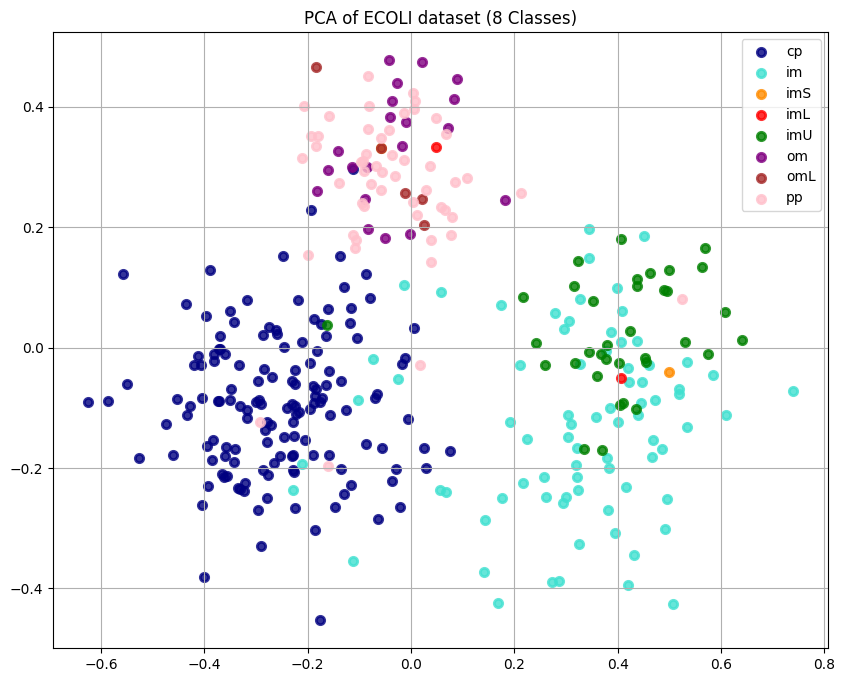

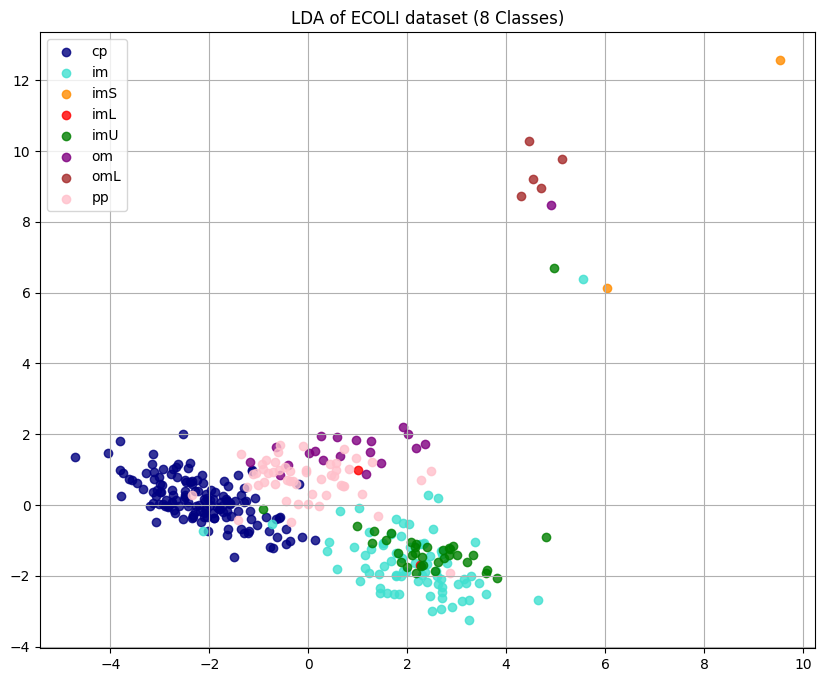

In [13]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


# --- Persiapan Data (Sama seperti sebelumnya) ---
X = df.drop(columns=["id", "protein_name", "localization_class"]).values
y = df["localization_class"].astype("category").cat.codes.values
target_names = df["localization_class"].unique()

# --- Model PCA dan LDA (Sama seperti sebelumnya) ---
pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)

lda = LinearDiscriminantAnalysis(n_components=2)
X_r2 = lda.fit(X, y).transform(X)

print(
    "explained variance ratio (first two components): %s"
    % str(pca.explained_variance_ratio_)
)

# --- Visualisasi PCA (Diperbaiki) ---
plt.figure(figsize=(10, 8))
# Menyiapkan 8 warna untuk 8 kelas
colors = ['navy', 'turquoise', 'darkorange', 'red', 'green', 'purple', 'brown', 'pink']
lw = 2

# Loop melalui semua kelas (bukan hanya 3)
for color, i, target_name in zip(colors, range(len(target_names)), target_names):
    plt.scatter(
        X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=0.8, lw=lw, label=target_name
    )
plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("PCA of ECOLI dataset (8 Classes)")
plt.grid(True)

# --- Visualisasi LDA (Diperbaiki) ---
plt.figure(figsize=(10, 8))
# Menggunakan warna yang sama untuk konsistensi
for color, i, target_name in zip(colors, range(len(target_names)), target_names):
    plt.scatter(
        X_r2[y == i, 0], X_r2[y == i, 1], alpha=0.8, color=color, label=target_name
    )
plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("LDA of ECOLI dataset (8 Classes)")
plt.grid(True)

plt.show()

Penyeimbangan data

In [7]:
import numpy as np
unique, counts = np.unique(y, return_counts=True)
print(dict(zip(unique, counts)))

{0: 143, 1: 77, 2: 2, 3: 2, 4: 35, 5: 20, 6: 5, 7: 52}


In [8]:
from imblearn.over_sampling import RandomOverSampler, ADASYN
import numpy as np

# Step 1: RandomOverSampler dulu
ros = RandomOverSampler(random_state=42)
X_ros, y_ros = ros.fit_resample(X, y)

print("Setelah ROS:", dict(zip(*np.unique(y_ros, return_counts=True))))

# Step 2: Baru ADASYN
adasyn = ADASYN(random_state=42, sampling_strategy="auto")
X_res, y_res = adasyn.fit_resample(X_ros, y_ros)

print("Sebelum ADASYN:", np.bincount(y_ros))
print("Sesudah ADASYN:", np.bincount(y_res))


Setelah ROS: {0: 143, 1: 143, 2: 143, 3: 143, 4: 143, 5: 143, 6: 143, 7: 143}
Sebelum ADASYN: [143 143 143 143 143 143 143 143]
Sesudah ADASYN: [143 143 143 143 143 143 143 143]


Visual Plot Data

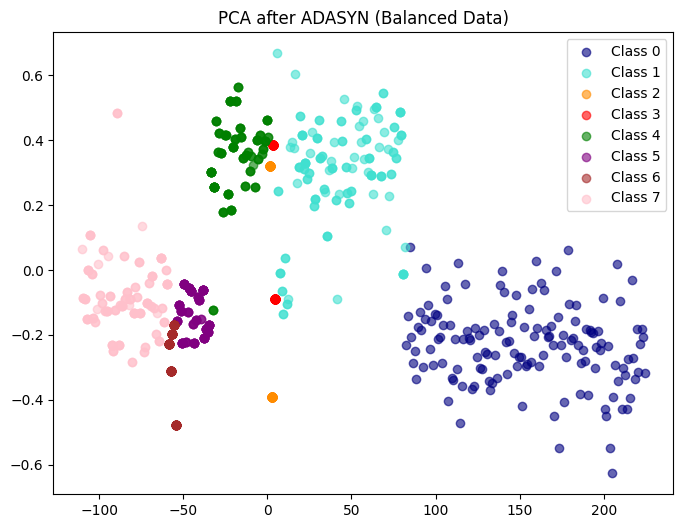

In [9]:
# PCA untuk data yang sudah diimbangkan
X_res_pca = PCA(n_components=2).fit_transform(X_res)

plt.figure(figsize=(8,6))

# Warna untuk kelas asli
colors = ["navy", "turquoise", "darkorange", "red", "green", "purple", "brown", "pink"]

for color, i, target_name in zip(colors, range(len(np.unique(y_res))), np.unique(y_res)):
    plt.scatter(
        X_res_pca[y_res == i, 0],
        X_res_pca[y_res == i, 1],
        alpha=0.6,
        color=color,
        label=f"Class {i}"
    )

plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("PCA after ADASYN (Balanced Data)")
plt.show()


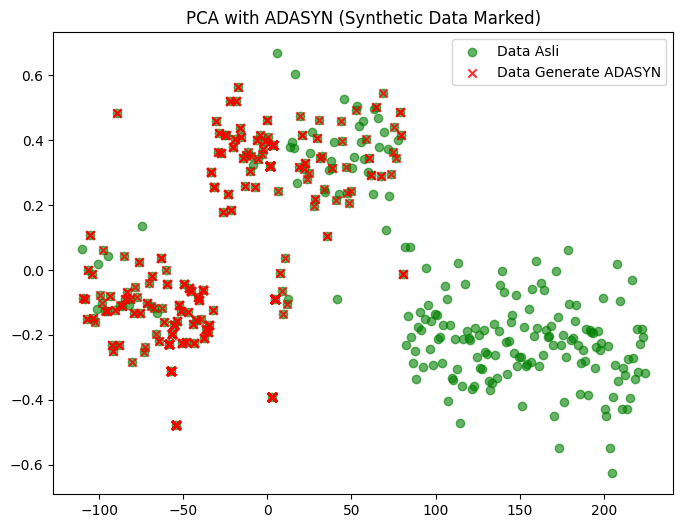

In [10]:
# Mask data hasil generate (ADASYN mengembalikan X_res, tapi kita bisa cek jumlah tambahan)
X_new = X_res[len(X):]   # data sintetis baru
y_new = y_res[len(y):]   # label sintetis baru

# PCA pada semua data
X_res_pca = PCA(n_components=2).fit_transform(X_res)

plt.figure(figsize=(8,6))

# Plot data asli
plt.scatter(X_res_pca[:len(X), 0], X_res_pca[:len(X), 1],
            alpha=0.6, c='green', label='Data Asli')

# Plot data hasil ADASYN
plt.scatter(X_res_pca[len(X):, 0], X_res_pca[len(X):, 1],
            alpha=0.8, c='red', marker='x', label='Data Generate ADASYN')

plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("PCA with ADASYN (Synthetic Data Marked)")
plt.show()
